
<a name='imports'>

# <span style='color:white'>Importing & Setup</span> 

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [2]:
SAVE = False
SEED = 111

tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})


***
<a name='import_data'>
    
#  <span style='color:white'>Importing Data</span> 

In [3]:
def get_data_labels(directory, shuffle=True, random_state=0):

    from sklearn.utils import shuffle
    import os

    data_path = []
    data_labels = []
    
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)

        if not os.path.isdir(label_dir):
            continue

        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_labels.append(label)
            
    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)
            
    return data_path, data_labels

In [4]:
USER_PATH = r"Data"
normal = USER_PATH + r'/'
tumor = USER_PATH + r'/Tumor'

normal_paths, normal_labels = get_data_labels(normal, shuffle=False)
tumor_paths, tumor_labels = get_data_labels(tumor, shuffle=False)

print('Normal Brain Scans')
print(f'Number of Paths: {len(normal_paths)}')
print(f'Number of Labels: {len(normal_labels)}')
print('\nTumor Brain Scans')
print(f'Number of Paths: {len(tumor_paths)}')
print(f'Number of Labels: {len(tumor_labels)}')

Normal Brain Scans
Number of Paths: 3069
Number of Labels: 3069

Tumor Brain Scans
Number of Paths: 18606
Number of Labels: 18606


In [6]:
print(f'Some Tumor labels: {tumor_labels[500:505]}')

tumor_labels = [path.replace('_tumor', '').title() for path in tumor_labels]

print(f'Some Tumor labels: {tumor_labels[500:505]}')

Some Tumor labels: ['glioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'pituitary_tumor', 'glioma_tumor']
Some Tumor labels: ['Glioma', 'Glioma', 'Pituitary', 'Pituitary', 'Glioma']


***
<a name='DP'>
    
#  <span style='color:white'>Data Processing</span> 

In [7]:
from sklearn.model_selection import train_test_split

MRI_paths = normal_paths + tumor_paths
MRI_labels = normal_labels + tumor_labels

train_paths, test_paths, train_labels, test_labels = train_test_split(
    MRI_paths, MRI_labels, test_size=0.35, random_state=SEED
)

train_df = pd.DataFrame({'path': train_paths, 'label': train_labels})
test_df = pd.DataFrame({'path': test_paths, 'label': test_labels})

In [8]:
train_df = train_df[train_df['label'] != 'Tumor']
test_df = test_df[test_df['label'] != 'Tumor']


In [9]:
CLASS_TYPES = pd.unique(train_df['label'])
N_TYPES = len(CLASS_TYPES)

print(f'Classes: {CLASS_TYPES} and length {N_TYPES}')

Classes: ['Normal' 'Meningioma' 'Glioma' 'Pituitary'] and length 4


In [10]:
tumor_classes = {'Normal': 0,
                 'Glioma': 1,
                 'Meningioma': 2,
                 'Pituitary': 3
}


train_df['label_encoded'] = train_df['label'].map(tumor_classes)
test_df['label_encoded'] = test_df['label'].map(tumor_classes)
display(train_df)
display(test_df)

,path,label,label_encoded
0,Data/Normal\N_60_DA_.jpg,Normal,0
1,Data/Tumor\meningioma_tumor\M_730_SP_.jpg,Meningioma,2
2,Data/Tumor\meningioma_tumor\M_883_BR_.jpg,Meningioma,2
3,Data/Tumor\glioma_tumor\G_112_BR_.jpg,Glioma,1
4,Data/Tumor\glioma_tumor\G_576.jpg,Glioma,1
...,...,...,...
14083,Data/Tumor\pituitary_tumor\P_308_SP_.jpg,Pituitary,3
14084,Data/Tumor\meningioma_tumor\M_175_BR_.jpg,Meningioma,2
14085,Data/Tumor\pituitary_tumor\P_287_BR_.jpg,Pituitary,3
14086,Data/Tumor\pituitary_tumor\P_713_HF_.jpg,Pituitary,3


,path,label,label_encoded
0,Data/Tumor\pituitary_tumor\P_540_RO_.jpg,Pituitary,3
1,Data/Tumor\glioma_tumor\G_871.jpg,Glioma,1
2,Data/Tumor\meningioma_tumor\M_791_RO_.jpg,Meningioma,2
3,Data/Tumor\pituitary_tumor\P_665.jpg,Pituitary,3
4,Data/Tumor\pituitary_tumor\P_207_RO_.jpg,Pituitary,3
...,...,...,...
7582,Data/Tumor\glioma_tumor\G_546_SP_.jpg,Glioma,1
7583,Data/Tumor\meningioma_tumor\M_469_HF_.jpg,Meningioma,2
7584,Data/Normal\N_176_DA_.jpg,Normal,0
7585,Data/Tumor\pituitary_tumor\P_163_DA_.jpg,Pituitary,3


Training Counts
{'Normal': 2003, 'Meningioma': 4172, 'Glioma': 4059, 'Pituitary': 3852}

Testing Counts
{'Normal': 1063, 'Meningioma': 2219, 'Glioma': 2248, 'Pituitary': 2056}


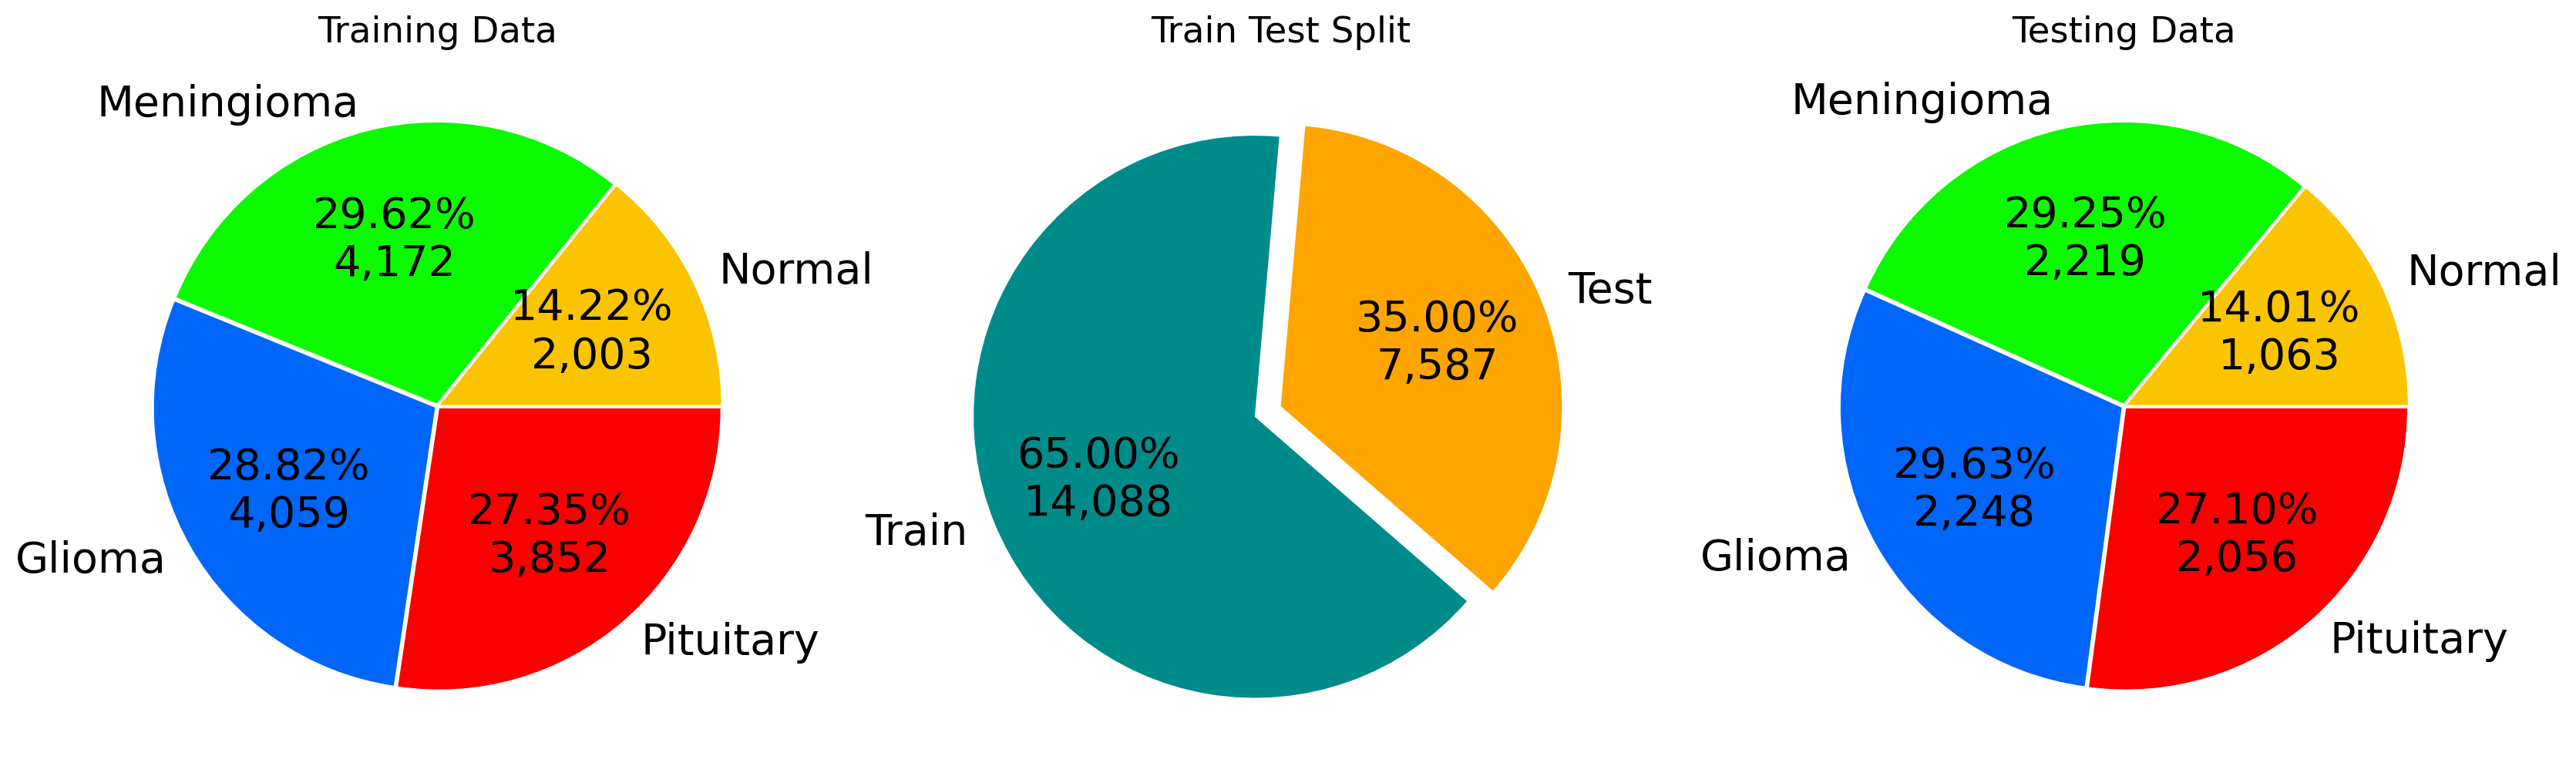

In [11]:
_, ax = plt.subplots(ncols=3, figsize=(20, 14))

class_counts = [len([x for x in train_labels if x == label]) for label in CLASS_TYPES]
print('Training Counts')
print(dict(zip(CLASS_TYPES, class_counts)))

ax[0].set_title('Training Data')
ax[0].pie(
    class_counts,
    labels=CLASS_TYPES,
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),
    textprops={'fontsize': 20}
)

ax[1].set_title('Train Test Split')
ax[1].pie(
    [len(train_labels), len(test_labels)],
    labels=['Train','Test'],
    colors=['darkcyan', 'orange'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([len(train_labels), len(test_labels)]) / 100),
    explode=(0.1, 0),
    startangle=85,
    textprops={'fontsize': 20}
)

class_counts = [len([x for x in test_labels if x == label]) for label in CLASS_TYPES]
print('\nTesting Counts')
print(dict(zip(CLASS_TYPES, class_counts)))

ax[2].set_title('Testing Data')
ax[2].pie(
    class_counts,
    labels=CLASS_TYPES,
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),  
    textprops={'fontsize': 20}  
)


plt.show()


***
<a name='vis'>
    
# <span style='color:white'>Data Visualization</span> 

x reshaped: (1, 150, 150, 3)


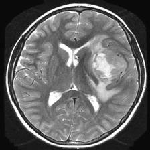

In [12]:
im = load_img(train_paths[3], target_size=(150, 150))
im = img_to_array(im)

im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}')

im /= np.max(im) 

im = array_to_img(im[0])
display(im)

In [13]:
def show_images(paths, label_paths, index_list=range(10), im_size=250, figsize=(12, 8), save=False):
    """
    Show images from a given path based on the inputted
    list indices related to the desired images one wishes
    to see.
    """

    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    
    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        
        image = load_img(paths[index], target_size=(im_size, im_size))
        ax[i].imshow(image)
        ax[i].set_title(f'{index}: {label_paths[index]}')
        ax[i].axis('off')

    plt.tight_layout()
    
    if save:
        plt.savefig('show_image.pdf')
    else:
        plt.show()

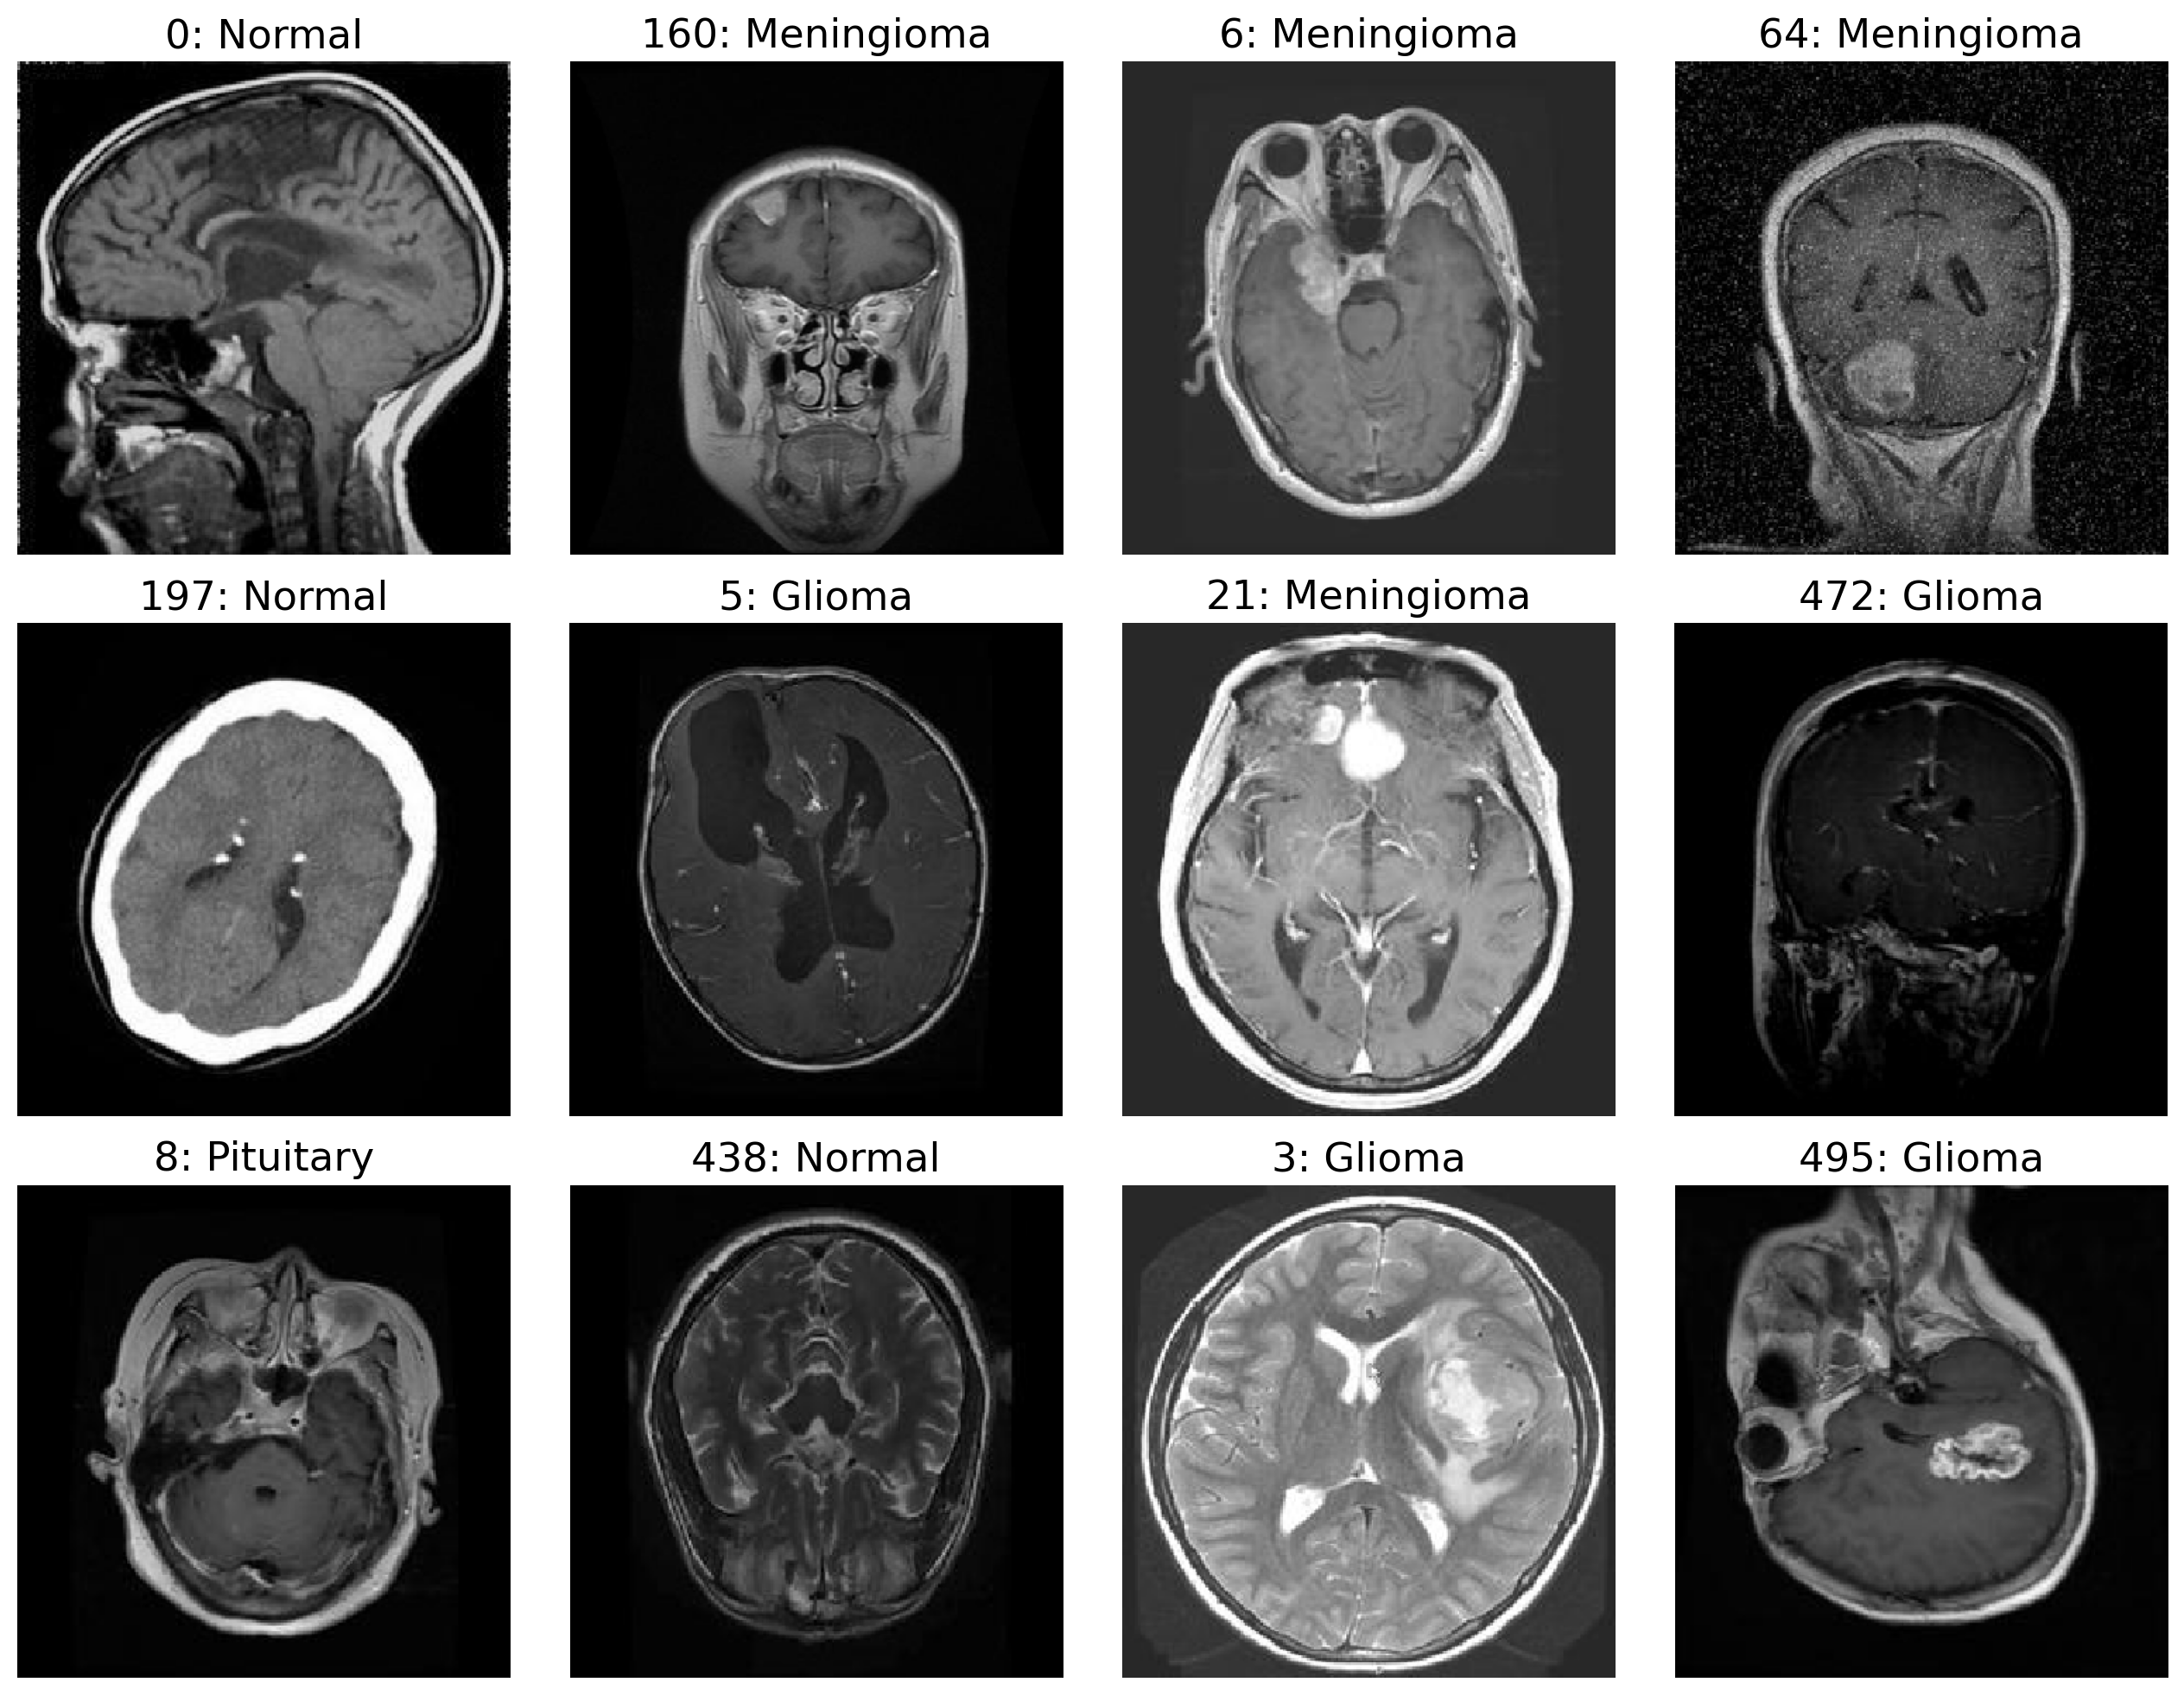

In [14]:
show_images(train_paths, 
            train_labels, 
            index_list=[0, 160, 6, 64,
                        197, 5, 21, 472,
                        8, 438, 3, 495], 
            im_size=350, 
            figsize=(13,10),
            save=SAVE)

In [15]:
image_size = (150, 150)
image_shape = (image_size[0], image_size[1], 1)

epochs = 20
batch_size = 150

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

Image shape: (150, 150, 1)
Epochs: 20
Batch size: 150


In [16]:
def img_preprocessing(image_path, label_encoded):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    
    img = tf.image.rgb_to_grayscale(img)
    
    img = tf.image.resize(img, size=(150, 150))
    img = img / 255.0
    
    return img, tf.one_hot(label_encoded, depth=N_TYPES)

train_loader = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['label_encoded']))
train_dataset = (train_loader.map(img_preprocessing
                                 ).batch(batch_size).shuffle(train_df['path'].shape[0]).prefetch(batch_size))

test_loader = tf.data.Dataset.from_tensor_slices((test_df['path'], test_df['label_encoded']))
test_dataset = (test_loader.map(img_preprocessing
                               ).batch(batch_size).shuffle(test_df['path'].shape[0]).prefetch(batch_size))


***
<a name='CNN'>
    
#  <span style='color:white'>CNN Model</span>

In [23]:
model = models.Sequential()

model.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3))) #

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(Flatten())

model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5, seed=SEED))
model.add(Dense(N_TYPES, activation="softmax"))

model.summary()


optimizer = Adam(learning_rate=0.001, beta_1=0.87, beta_2=0.9995)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 147, 147, 32)   │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 505,188 (1.93 MB)

 Trainable params: 505,188 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=6, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=True)
model_cp = ModelCheckpoint('best_weights.keras', save_best_only=True, monitor='val_accuracy')

history = model.fit(train_dataset,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=test_dataset,
                    callbacks=[model_es, model_rlr, model_cp])

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 46s 447ms/step - accuracy: 0.4554 - loss: 1.1875 - val_accuracy: 0.6558 - val_loss: 0.8246 - learning_rate: 0.0010
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 539ms/step - accuracy: 0.6747 - loss: 0.7770 - val_accuracy: 0.7416 - val_loss: 0.5915 - learning_rate: 0.0010
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 63s 591ms/step - accuracy: 0.7903 - loss: 0.5287 - val_accuracy: 0.8499 - val_loss: 0.4054 - learning_rate: 0.0010
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 49s 473ms/step - accuracy: 0.8672 - loss: 0.3591 - val_accuracy: 0.8880 - val_loss: 0.3197 - learning_rate: 0.0010
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 594ms/step - accuracy: 0.9125 - loss: 0.2377 - val_accuracy: 0.9106 - val_loss: 0.2521 - learning_rate: 0.0010
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 63s 616ms/step - accuracy: 0.9402 - loss: 0.1647 - val_accuracy: 0.9263 - val_loss: 0.2181 - learning_rate: 0.0010
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 62s 592ms/step - accuracy: 0.9542 - loss: 0.

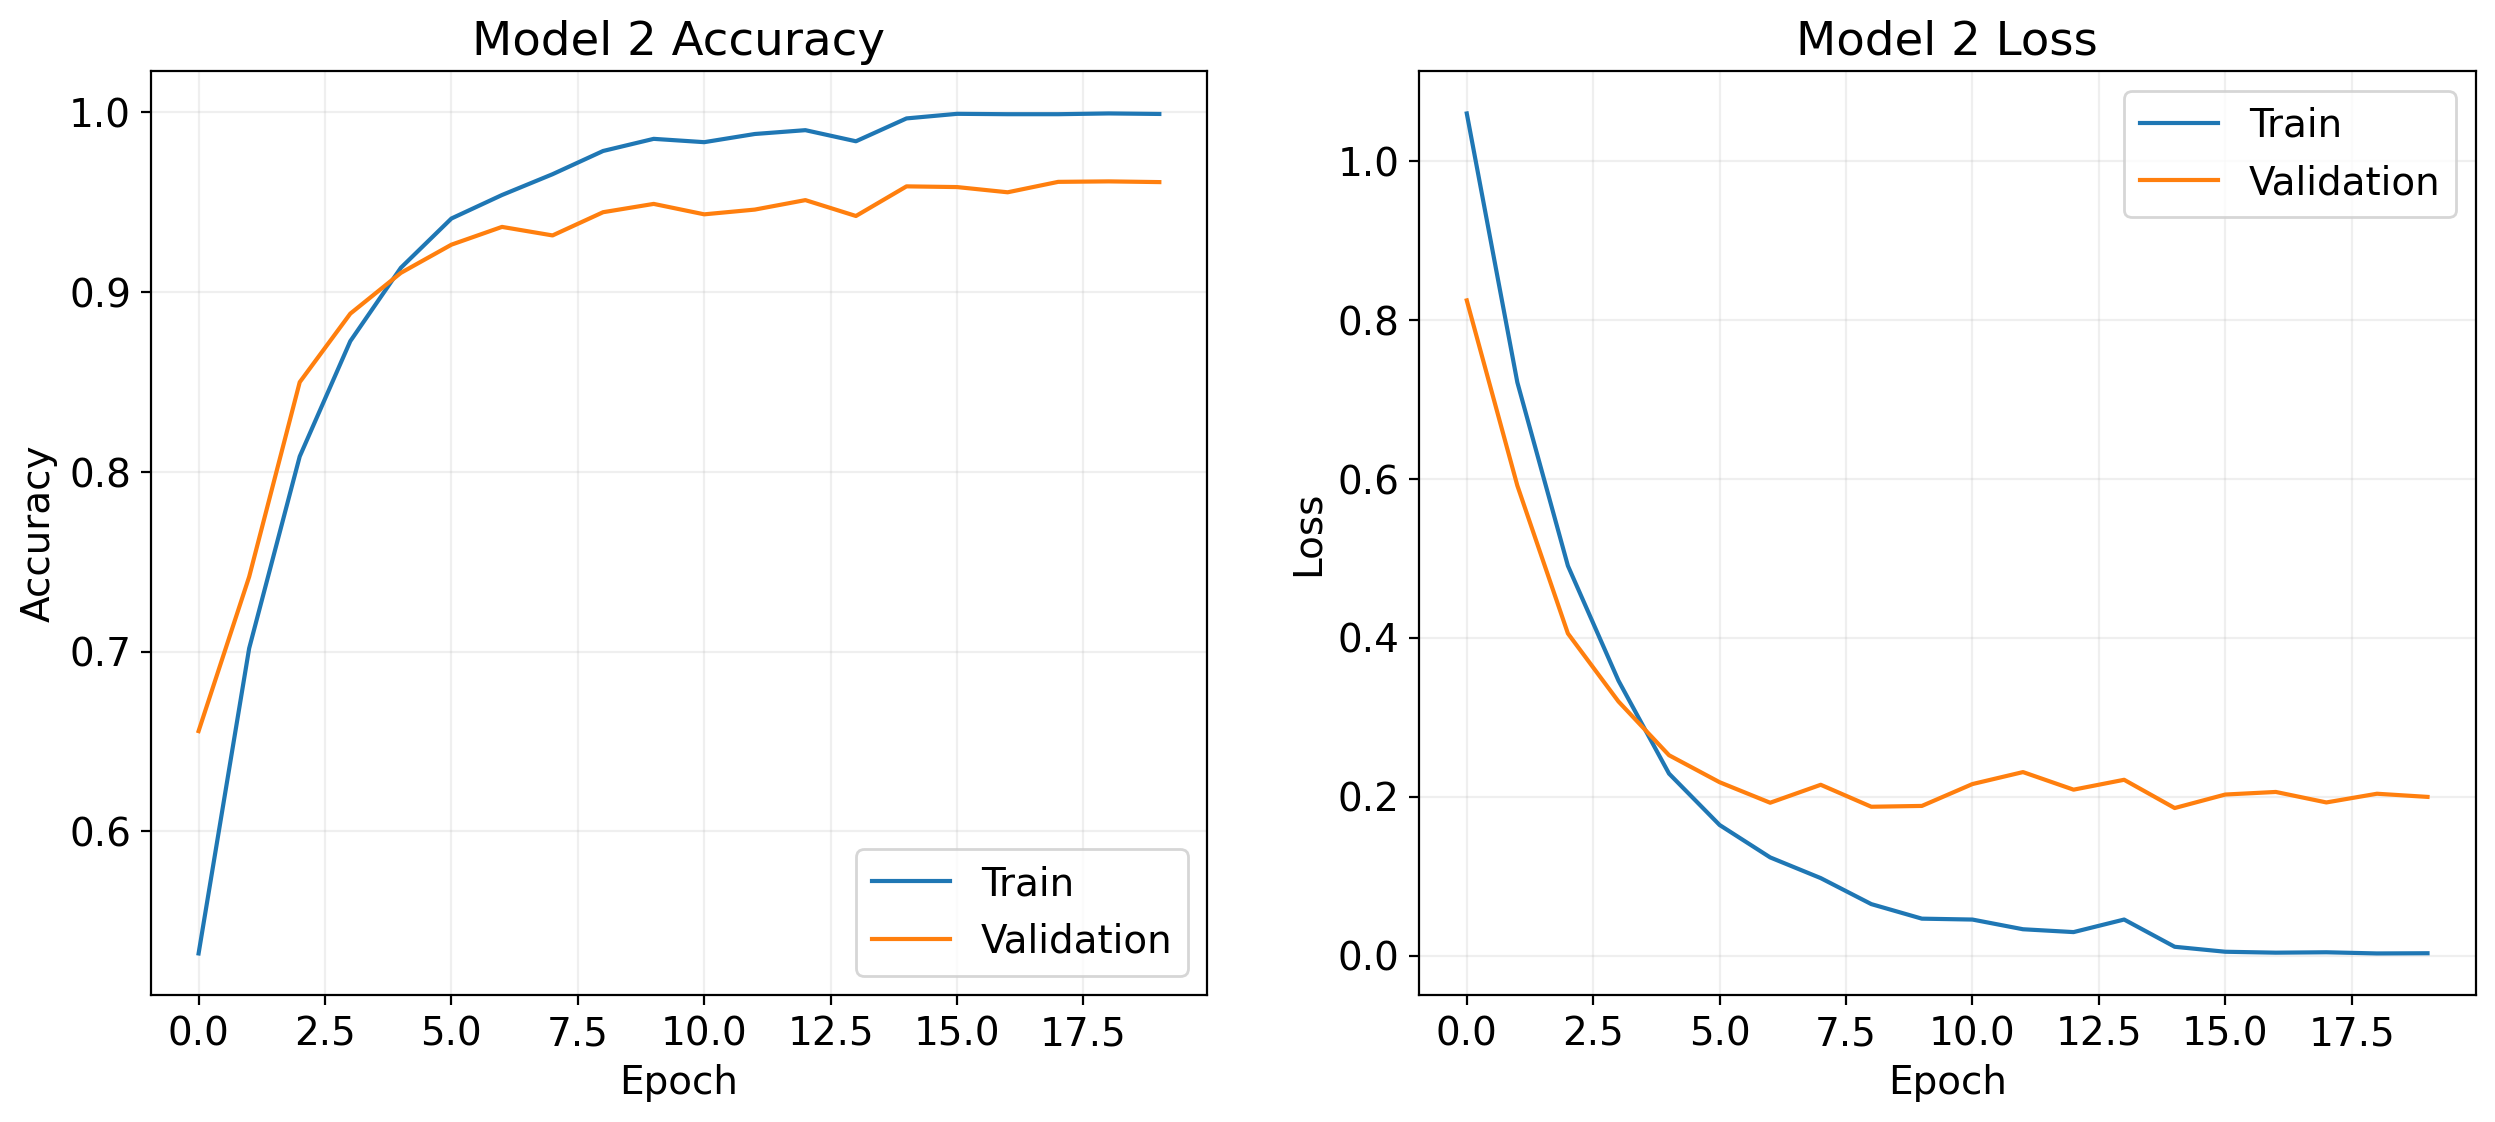

In [41]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model 2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

In [45]:
from tensorflow.keras.models import load_model

model = load_model('best_weights.keras')

In [48]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(9, 9))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()

def generate_confusion_matrix(model, test_dataset, class_names):
    
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix

    true_labels = []
    predicted_labels = []

    for batch in test_dataset:
        images, labels = batch

        predictions = model.predict(images, verbose=False)
        predicted_classes = np.argmax(predictions, axis=1)

        true_classes = np.argmax(labels, axis=1)

        true_labels.extend(true_classes)
        predicted_labels.extend(predicted_classes)

    cm = confusion_matrix(true_labels, predicted_labels)

    class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print("Classification Report:\n", class_report)
    
    return cm

In [47]:
cm = generate_confusion_matrix(model, test_dataset, list(tumor_classes.keys()))

Classification Report:
               precision    recall  f1-score   support

      Normal       0.97      0.97      0.97      1063
      Glioma       0.95      0.95      0.95      2248
  Meningioma       0.95      0.95      0.95      2219
   Pituitary       0.98      0.98      0.98      2056

    accuracy                           0.96      7586
   macro avg       0.96      0.96      0.96      7586
weighted avg       0.96      0.96      0.96      7586



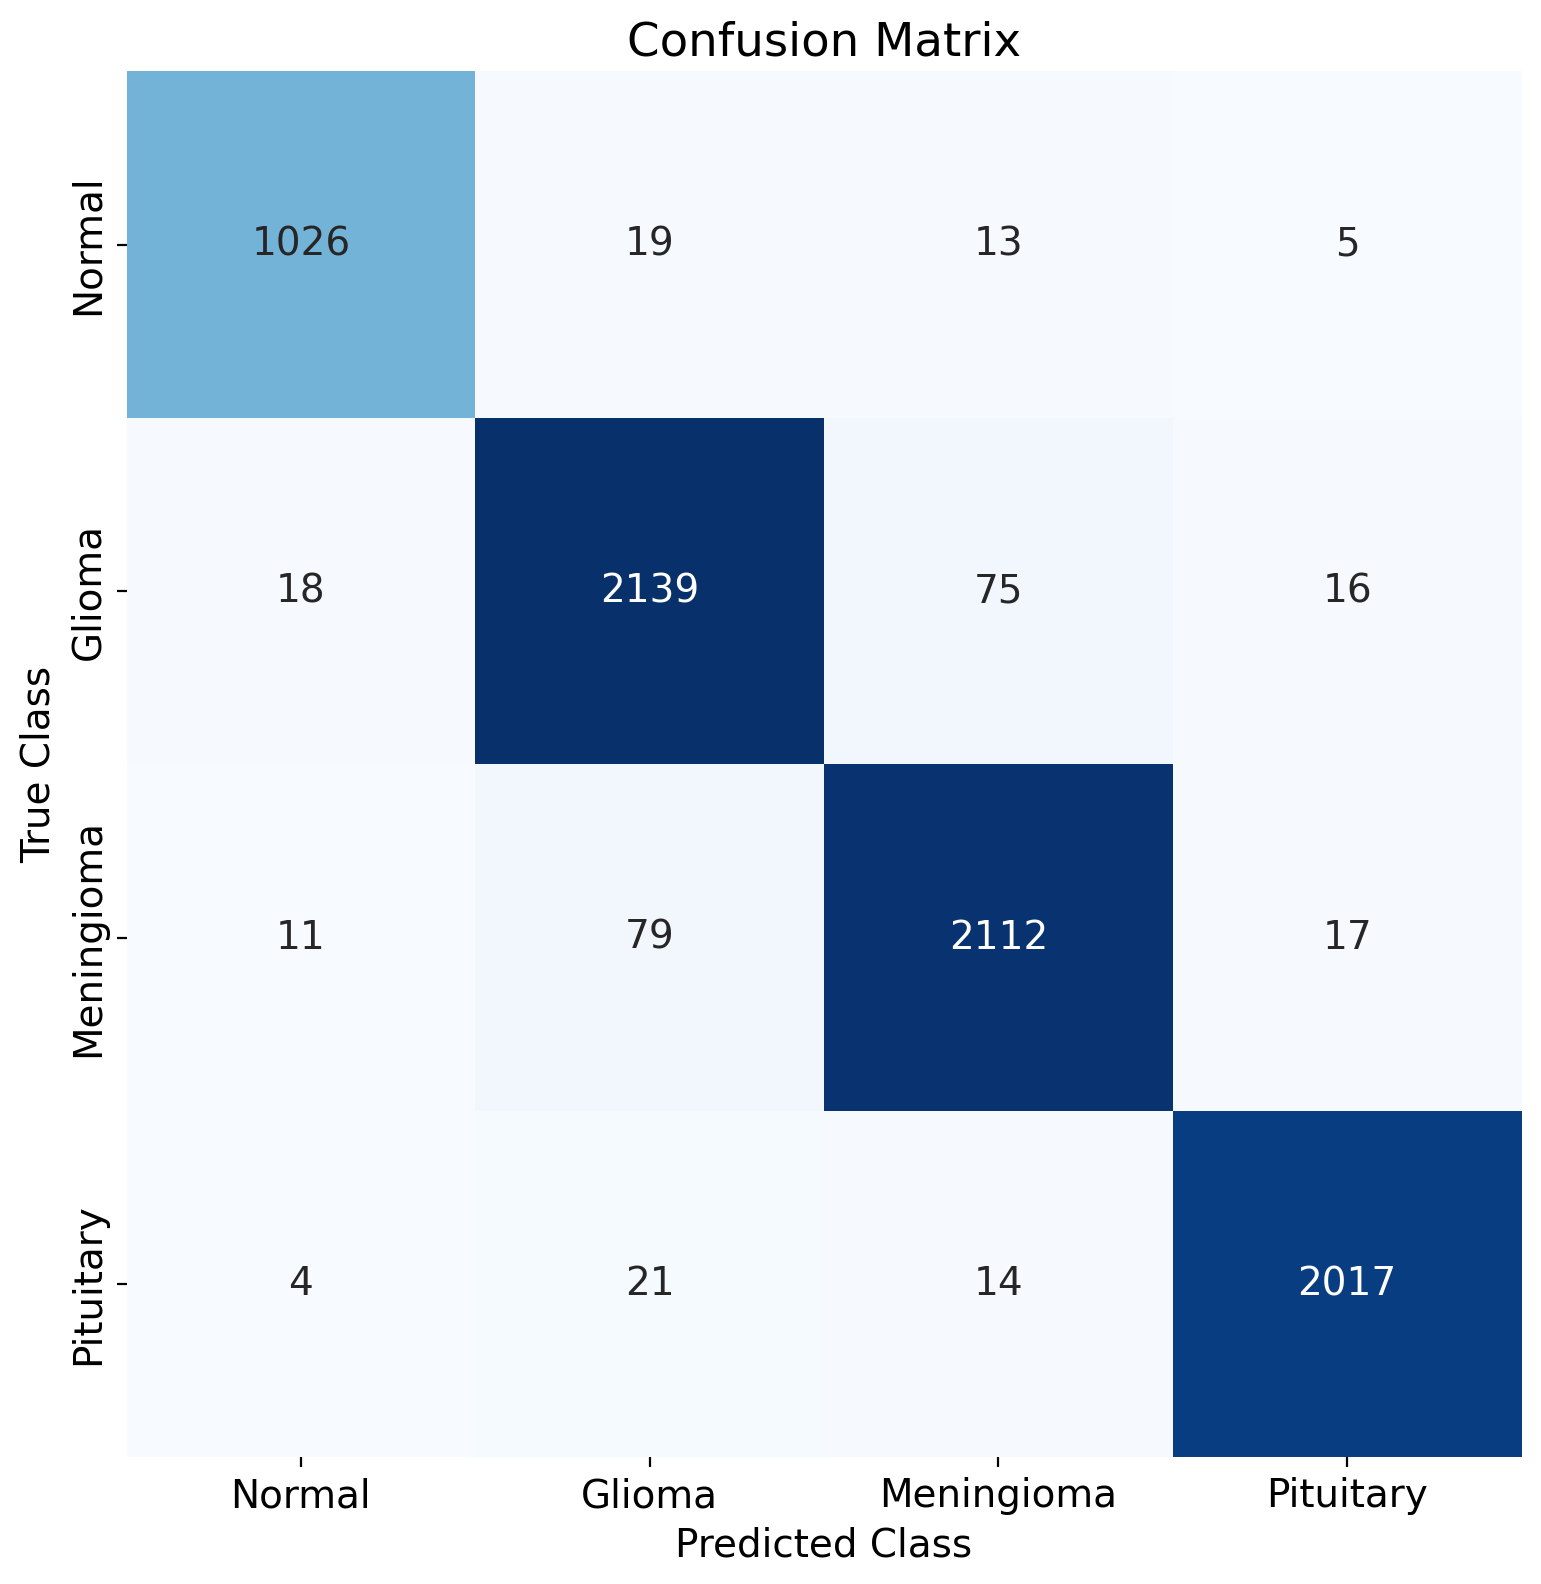

In [49]:
plot_confusion_matrix(cm, list(tumor_classes.keys()))

In [50]:
def plot_channel_activation_maps(model, image, images_per_row=16, N=8, save=False):

    from tensorflow.keras.models import Model
    
    activation_model = Model(inputs=model.input, outputs=[layer.output for layer in model.layers[:N]])
    activations = activation_model.predict(image)

    layer_names = [layer.name for layer in model.layers[:N]]

    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                epsilon = 1e-8  
                channel_std = channel_image.std() + epsilon
                channel_image /= channel_std
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size: (col + 1) * size,
                             row * size: (row + 1) * size] = channel_image

        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.axis('off')
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

        if save:
            plt.savefig(f'plot_channel_activation_maps_{layer_name}.pdf')

    plt.show()

In [52]:
path, label = test_df.iloc[0, 0], test_df.iloc[0, 1]
print(path, label)

Data/Tumor\pituitary_tumor\P_540_RO_.jpg Pituitary


x reshaped: (1, 150, 150, 1)
Class name of the first image: Pituitary


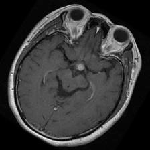

In [53]:
im = load_img(path, target_size=(150, 150), color_mode="grayscale")
im = img_to_array(im)

image_tensor = np.expand_dims(im, axis=0)
print(f'x reshaped: {image_tensor.shape}')

image_tensor /= np.max(image_tensor) 

print(f"Class name of the first image: {label}")
array_to_img(im)